# Рынок недвижимости


На этот раз мы будем выполнять задание, связанное с рынком недвижимости. Мы хотим построить модель, ориентированную на цены на рынке недвижимости Варшавы.

In [61]:
import pandas as pd
import numpy as np
np.random.seed(0)

import re
import sys


from ml_metrics import rmsle
from sklearn.model_selection import KFold, learning_curve
from sklearn.model_selection import ShuffleSplit

from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import xgboost as xgb
import catboost as ctb
from functools import partial
from hyperopt import hp
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Подготовка данных


In [2]:
train = pd.read_hdf('../input/train.realestate_row.h5')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19144 entries, 0 to 0
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   building            18683 non-null  object
 1   extra_benefits      9734 non-null   object
 2   parking             6854 non-null   object
 3   apartament          18874 non-null  object
 4   offer               18876 non-null  object
 5   surroundings        19144 non-null  object
 6   extra_description   16732 non-null  object
 7   benefit_investment  1383 non-null   object
 8   broker_license      19144 non-null  object
 9   stats               19144 non-null  object
 10  broker_id           19144 non-null  int16 
 11  broker_company_id   19144 non-null  int16 
dtypes: int16(2), object(10)
memory usage: 1.7+ MB


In [4]:
train.head()

,building,extra_benefits,parking,apartament,offer,surroundings,extra_description,benefit_investment,broker_license,stats,broker_id,broker_company_id
0,"{'Typ budynku': 'apartamentowiec', 'Liczba pię...",NaN,garaż,"{'Łazienka': 'w aneksie', 'Liczba pokoi': 'par...",699 000 zł (4 288 zł/m,{'Zdrowie': [' ...,[OSTATNIE WOLNE LOKALE !!!!!!!!!! OSIED...,NaN,,"[[Źródło: , Osoba prywatna], [Rynek: , wtórny]...",0,0
0,"{'Typ budynku': 'apartamentowiec', 'Liczba pię...",NaN,NaN,"{'Liczba pokoi': '8', 'Kuchnia': 'bardzo dobry...",560 000 zł (8 917 zł/m,{'Zdrowie': [' ...,[Mieszkanie typu studio na warszawskiej Ochoci...,NaN,,"[[Źródło: , Biuro nieruchomości], [Rynek: , wt...",1,1
0,"{'Typ budynku': 'blok', 'Liczba pięter': '4', ...","centralne ogrzewanie, domofon, teren ogrodzony",NaN,"{'Łazienka': 'z oknem, oddzielna', 'Liczba pok...",309 000 zł (6 119 zł/m,{'Zdrowie': [' ...,"[Oferujemy mieszkanie na 3 piętrze, dwustronne...",NaN,,"[[Źródło: , Osoba prywatna], [Rynek: , wtórny]...",2,0
0,"{'Typ budynku': 'blok', 'Liczba pięter': '4', ...",NaN,NaN,"{'Liczba pokoi': 'parter', 'Kuchnia': 'do remo...",270 000 zł (7 297 zł/m,{},"[Witam, oferuję Państwu mieszkanie na spokojny...",NaN,Nr licencji pośrednika: 11710,"[[Źródło: , Biuro nieruchomości], [Rynek: , wt...",3,2
0,"{'Typ budynku': 'blok', 'Liczba pięter': '3', ...",NaN,NaN,"{'Liczba pokoi': '3', 'Kuchnia': '3', 'Forma w...",500 000 zł (7 042 zł/m,{'Zdrowie': [' ...,[Jeśli chcesz mieszkać w doskonale skomunikowa...,NaN,,"[[Źródło: , Biuro nieruchomości], [Rynek: , wt...",4,3


In [5]:
train['building'].value_counts()

{'Typ budynku': 'blok', 'Liczba pięter': '4'}                                                              296
{'Typ budynku': 'blok', 'Liczba pięter': '6'}                                                              229
{'Typ budynku': 'blok', 'Liczba pięter': '25'}                                                             193
{'Typ budynku': 'blok', 'Liczba pięter': '8'}                                                              179
{'Typ budynku': 'blok', 'Liczba pięter': '10'}                                                             150
                                                                                                          ... 
{'Typ budynku': 'apartamentowiec', 'Liczba pięter': '12', 'Rok budowy': '2017', 'Materiał': 'mieszany'}      1
{'Typ budynku': 'wieżowiec', 'Liczba pięter': '18', 'Rok budowy': '2003'}                                    1
{'Typ budynku': 'wieżowiec', 'Liczba pięter': '8', 'Rok budowy': '2004', 'Materiał': 'rama H'}               1
{

In [6]:
def get_value(items, key, type_value=np.int8, filter_=None):
    try:
        value = filter_(items[key]) if filter_ else items[key]
        return type_value(value)
    except:
        #print(items)
        return -1
    
def num_filter(val):
    return re.sub('[^0-9]','', val)

def float_filter(val):
    return re.sub('[^0-9\,\.]','', val).replace(',', '.')

def str_filter(val):
    return val.lower().strip()

## Объявление
Оно состоит из нескольких разделов:
- здание (информация о здании)
- квартира
- дополнительное описание
- район
- преимущества
- ...

Каждый раздел содержит различную информацию (также в другом формате). Поэтому в «сырой» версии данных `train_row.h5` в одном столбце находится словарь или список, из которого нужно извлечь информацию и разбить ее на отдельные столбцы.

## Здание
Извлекаем 4 признака:
* Количество этажей
* Тип здания
* Год постройки
* Материал

In [7]:
train['building_num_floor'] = train['building'].map(lambda x: get_value(x, 'Liczba pięter', np.int8, num_filter))
train['type_building'] = train['building'].map(lambda x: get_value(x, 'Typ budynku', str, str_filter ))
train['year_building'] = train['building'].map(lambda x: get_value(x, 'Rok budowy', np.int16, num_filter ))
train['material_building'] = train['building'].map(lambda x: get_value(x, 'Materiał', str, str_filter ))

Где:

- "**Liczba pięter**" - это в переводе с польского "**Количество этажей**"
- "**Typ budynku**" - это в переводе с польского "**Тип здания**"
- "**Rok budowy**" -  это в переводе с польского "**Год постройки**"
- "**Materiał**" -  это в переводе с польского "**Материал**"

## Дополнительные преимущества
Сначала мы создаем `set` с именем `all_benefits`. `Set` имеет свойство хранить только уникальные значения. Мы хотим проверить все возможные преимущества, перебирая столбец `extra_benefits` и помещая его в `all_benefits`.

Также нормализуем преимущества (делая все с маленькой буквы и удаляя пробелы в начале и конце).

In [8]:
all_benefits = set()

def extract_benefits(benefit):
    if 'nan' == str(benefit): return
    
    for value in benefit.split(','):
        value = value.lower().strip()
        if '' == value: continue
            
        all_benefits.add(value)
    
_ = train['extra_benefits'].map(extract_benefits)

all_benefits

{'antresola',
 'centralne ogrzewanie',
 'domofon',
 'internet',
 'loft',
 'ochrona',
 'ogrzewanie elektryczne',
 'ogrzewanie miejskie',
 'ogrzewanie podłogowe',
 'patio',
 'podjazd dla niepełnosprawnych',
 'recepcja',
 'telefon',
 'teren ogrodzony',
 'tv kablowa',
 'wideofon',
 'winda'}

Где:

 - '**antresola**' - в переводе с польского "**антресоль (обычно в стиле лофт, когда при наличии высоких потолков могут создавать второй ярус в комнате для рабочего пространства/спального места)**" 
 - '**centralne ogrzewanie**' - в переводе с польского "**центральное отопление**"
 - '**domofon**' - в переводе с польского "**домофон**"
 - '**internet**' - в переводе с польского "**интернет**"
 - '**loft**' - в переводе с польского "**чердак**"
 - '**ochrona**' - в переводе с польского "**охрана**"
 - '**ogrzewanie elektryczne**' - в переводе с польского "**электрическое отопление**"
 - '**ogrzewanie miejskie**' - в переводе с польского "**муниципальное отопление**"
 - '**ogrzewanie podłogowe**' - в переводе с польского "**теплый пол**"
 - '**patio**' - в переводе с польского "**внутренний дворик**"
 - '**podjazd dla niepełnosprawnych**' - в переводе с польского "**подъезд для инвалидов**"
 - '**recepcja**' - в переводе с польского "**рецепция**"
 - '**telefon**' - в переводе с польского "**телефон**"
 - '**teren ogrodzony**' - в переводе с польского "**огороженная территория**"
 - '**tv kablowa**' - в переводе с польского "**кабельное ТВ**"
 - '**wideofon**' - в переводе с польского "**видео-телефон**"
 - '**winda**' - в переводе с польского "**лифт**"

Имея все возможные преимущества (для нашего набора), мы создаем для каждого из них отдельный столбец. Если это преимущество существует для данной квартиры - значение столбца будет равно 1, в противном случае - 0.

In [9]:
idx_benefits, labels_benefits = pd.factorize( list(all_benefits) )

for idx_benefit in idx_benefits:
    cat_name = 'benefit_{0}'.format( labels_benefits[idx_benefit].replace(' ', '_') )
    ben_label = labels_benefits[idx_benefit]
    
    train[cat_name] = train['extra_benefits'].map(lambda x: int(ben_label in x.lower()) if 'nan' != str(x) else 0 )

## Стоимость 

десятичные разряды для чисел указаны после запятой. Однако, чтобы преобразовать их в `float`,  должна быть точка, поэтому использовалась функция` .replace (',', '.')`.



Используя `split`, мы можем получить общую стоимость. В конечном итоге это выглядело так: **458 094 zł (польских злотых) (7 800 zł/m2 )**, и с помощью `split` мы делим строку на две части: перед 'zł и после. В нашем случае нам нужна первая часть (потому что в нее включена стоимость), поэтому функция извлечения стоимости будет выглядеть так: `.split ('zł') [0]`.


In [10]:
'458 094 zł (7 800 zł/m '.split('zł')[0].replace(' ', '')

'458094'

Теперь мы добавляем этот код в функцию `get_price`. Дополнительно мы добавляем блок `try/except` на случай, если что-то пойдет не так. Например, иногда вместо цены стоит "Zapytaj o cenę" (польск. "Уточни стоимость"), в этом случае мы возвращаем: -1.

In [11]:
def get_price(value):
    try:
        if 'nan' == str(value): return np.nan        
        return float(value.split('zł')[0].replace(' ', '').replace(',', '.'))
    except:
        #print(value)
        return -1
    
train['price'] = train.offer.map(get_price)

#train.head()

<AxesSubplot:>

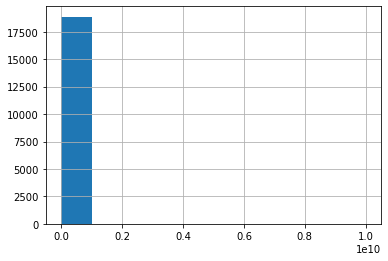

In [12]:
train['price'].hist()

## Квартира

Признаки квартиры.

Интересным фактом в данном случае является то, что при сборе данных возникла ошибка (как это часто бывает в жизни). Похоже, 2 из м2 указана в признаке квартиры. 2 после «m» выглядела как последовательное число (признак), в результате чего все признаки переместились на единицу.

#### Как должно было быть:
- площадь: 100м2
- признак1: A
- признак2: B
- признак3: C

#### Как получилось:
- площадь: 100м
- признак1: 2
- признак2: A
- признак3: B




In [13]:
orders = {
    'Forma własności': 1,
    'Powierzchnia': 2,
    'Piętro': 3,
    'Liczba pokoi': 4,
    'Liczba poziomów': 5,
    'Wykończenie': 6,
    'Stan mieszkania': 7,
    'Głośność': 8,
    'Kuchnia': 9,
    'Łazienka': 10,
    'Stan łazienki': 11,
    'Stan instalacji': 12,
    'Okna': 13,
    'Usytuowanie wzgl. stron świata': 14,
    'Powierzchnia dodatkowa': 15
}

def get_map_attrs(apartament):
    sorted_attrs = sorted([ (key, orders[key]) for key in apartament.keys()], key=lambda key: key[1])

    map_attrs = {}
    for idx, attr in enumerate(sorted_attrs):
        if attr[0] == 'Forma własności' or attr[0] == 'Powierzchnia': 
            map_attrs[attr[0]] = sorted_attrs[idx][0]
            continue

        if idx + 1 < len(sorted_attrs):
            map_attrs[attr[0]] = sorted_attrs[idx+1][0]
            
    return map_attrs
            
def do_apartament_fix(apartament):
    if 'nan' == str(apartament): return np.nan
    
    map_attrs = get_map_attrs(apartament)
    apartment_fix = {}
    for key in apartament:
        if key not in map_attrs: continue
        apartment_fix[key] = apartament[map_attrs[key]]
            
    return apartment_fix

train['apartament_fix'] = train['apartament'].map(do_apartament_fix)

Где:
- '**Forma własności**' - в переводе с польского "**Форма собственности**"
- '**Powierzchnia**'- в переводе с польского "**Площадь**"
- '**Piętro**' - в переводе с польского "**Этаж**"
- '**Liczba pokoi**'- в переводе с польского "**Количество комнат**"
- '**Liczba poziomów**'- в переводе с польского "**Количество уровней**"
- '**Wykończenie**'- в переводе с польского "**Отделка**"
- '**Stan mieszkania**'- в переводе с польского "**Состояние квартиры**"
- '**Głośność**'- в переводе с польского "**Громкость**"
- '**Kuchnia**'- в переводе с польского "**Кухня**"
- '**Łazienka**'- в переводе с польского "**Ванная комната**"
- '**Stan łazienki**'- в переводе с польского "**Состояние ванной комнаты**"
- '**Stan instalacji**'- в переводе с польского "**Состояние коммуникации**"
- '**Okna**'- в переводе с польского "**Окна**"
- '**Usytuowanie wzgl. stron świata**'- в переводе с польского "**Расположение по сторонам света**"
- '**Powierzchnia dodatkowa**'- в переводе с польского "**Дополнительная площадь**"

Теперь переменная `apartament_fix` имеет фиксированные значения. Извлекаем признаки квартир в отдельные столбцы.

In [14]:
train['apartament_ownership'] = train['apartament_fix'].map(lambda x: get_value(x, 'Forma własności', str, str_filter))
train['apartament_area'] = train['apartament_fix'].map(lambda x: get_value(x, 'Powierzchnia', float, float_filter))
train['apartament_floor'] = train['apartament_fix'].map(lambda x: get_value(x, 'Piętro', str, str_filter))
train['apartament_num_rooms'] = train['apartament_fix'].map(lambda x: get_value(x, 'Liczba pokoi', np.int8, num_filter))

train['apartament_num_levels'] = train['apartament_fix'].map(lambda x: get_value(x, 'Liczba poziomów', str, str_filter))
train['apartament_finished'] = train['apartament_fix'].map(lambda x: get_value(x, 'Wykończenie', str, str_filter))
train['apartament_condition'] = train['apartament_fix'].map(lambda x: get_value(x, 'Stan mieszkania', str, str_filter))
train['apartament_noise'] = train['apartament_fix'].map(lambda x: get_value(x, 'Głośność', str, str_filter))
train['apartament_kitchen'] = train['apartament_fix'].map(lambda x: get_value(x, 'Kuchnia', str, str_filter))
train['apartament_bathroom'] = train['apartament_fix'].map(lambda x: get_value(x, 'Łazienka', str, str_filter))
train['apartament_bahtroom_condition'] = train['apartament_fix'].map(lambda x: get_value(x, 'Stan łazienki', str, str_filter))
train['apartament_installation_condition'] = train['apartament_fix'].map(lambda x: get_value(x, 'Stan instalacji', str, str_filter))
train['apartament_window'] = train['apartament_fix'].map(lambda x: get_value(x, 'Okna', str, str_filter))
train['apartament_appartament'] = train['apartament_fix'].map(lambda x: get_value(x, 'Usytuowanie wzgl. stron świata', str, str_filter))

## Район
С помощью переменной `surroundings` мы получаем информацию о близлежащих объектах. Можно извлечь эти значения и сделать с ними что-нибудь стоящее;)

Их очень много. Из этой переменной можно сгенерировать гораздо больше признаков, чтобы поэкспериментировать.

In [15]:
train.head(1).surroundings[0]['Edukacja']

['\n                                              ',
 'Gimnazjum nr 5 Zespołu Szkół Prywatnych Free',
 ' - 1,7\xa0km',
 '\n                                              ',
 'Integracyjne Językowe Przedszkole Montessori,Klub Malucha i Żłobek',
 ' - 1,8\xa0km',
 '\n                                          ']

## Преимущества инвестиций
Это немного дублируется с другими полями (например, с дополнительным описанием), но в этом случае используются так называемые "ключевые слова".

In [16]:
all_benefits_investment = set()

def extract_benefits_investment(benefit):
    if 'nan' == str(benefit): return
    
    for value in benefit.split(','):
        value = value.lower().strip()
        if '' == value: continue
            
        all_benefits_investment.add(value)
    
_ = train['benefit_investment'].map(extract_benefits_investment)

all_benefits_investment

{'antresola',
 'centralne ogrzewanie',
 'domofon',
 'internet',
 'loft',
 'ochrona',
 'ogrzewanie miejskie',
 'ogrzewanie podłogowe',
 'patio',
 'podjazd dla niepełnosprawnych',
 'recepcja',
 'telefon',
 'teren ogrodzony',
 'tv kablowa',
 'wideofon',
 'winda'}

## Статистическая информация

In [17]:
list(train.stats.head(1))

[[['Źródło: ', 'Osoba prywatna'],
  ['Rynek: ', 'wtórny'],
  ['Dodano: ', 'więcej niż miesiąc temu'],
  ['Aktualizacja: ', 'dzisiaj'],
  ['Liczba odsłon: ', '2596']]]

Где:
- 'Źródło (Источник): ', 'Osoba prywatna (Частное лицо)'
- 'Rynek (Рынок): ', 'wtórny (Вторичный)'
- 'Dodano (Добавлено): ', 'więcej niż miesiąc temu (Больше месяца назад)' 
- 'Aktualizacja (Актуализация): ', 'dzisiaj (сегодня)'
- 'Liczba odsłon (Количество просмотров страниц): ', '2596'

In [18]:
train['stats_who'] = train.stats.map(lambda x: str(x[0][1].lower().strip()) if x else 'unknown')
train['stats_market'] = train.stats.map(lambda x: x[1][1].lower().strip() if x else 'unknown')
train['stats_created_at'] = train.stats.map(lambda x: x[2][1].lower().strip() if x else 'unknown')
train['stats_updated_at'] = train.stats.map(lambda x: x[3][1].lower().strip() if x else 'unknown')
train['stats_viewers'] = train.stats.map(lambda x: int(x[4][1].lower().strip()) if x and len(x) == 5 else -1)

biuro nieruchomości    16449
deweloper               2387
unknown                  268
osoba prywatna            28
instytucja                12
Name: stats_who, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)
Index(['osoba prywatna', 'biuro nieruchomości', 'deweloper', 'unknown',
       'instytucja'],
      dtype='object')


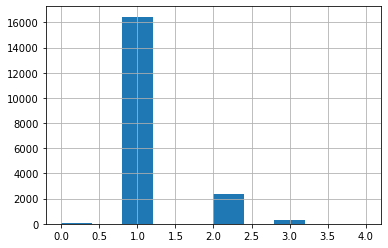

In [19]:
print(train['stats_who'].value_counts())
train['stats_who_cat'], labels = pd.factorize(train['stats_who'])
print( train['stats_who_cat'].hist() )
print(labels)

### stats_viewers
Значения слишком изменчивы для гистограммы, но их можно разбить на группы.

In [20]:
pd.qcut(train[ train.stats_viewers != -1 ]['stats_viewers'], 5).unique()

[(319.0, 90536.0], (189.0, 319.0], (119.0, 189.0], (3.999, 75.0], (75.0, 119.0]]
Categories (5, interval[float64]): [(3.999, 75.0] < (75.0, 119.0] < (119.0, 189.0] < (189.0, 319.0] < (319.0, 90536.0]]

In [21]:
train.head(1)

,building,extra_benefits,parking,apartament,offer,surroundings,extra_description,benefit_investment,broker_license,stats,...,apartament_bahtroom_condition,apartament_installation_condition,apartament_window,apartament_appartament,stats_who,stats_market,stats_created_at,stats_updated_at,stats_viewers,stats_who_cat
0,"{'Typ budynku': 'apartamentowiec', 'Liczba pię...",NaN,garaż,"{'Łazienka': 'w aneksie', 'Liczba pokoi': 'par...",699 000 zł (4 288 zł/m,{'Zdrowie': [' ...,[OSTATNIE WOLNE LOKALE !!!!!!!!!! OSIED...,NaN,,"[[Źródło: , Osoba prywatna], [Rynek: , wtórny]...",...,-1,nowa,nowe plastikowe,"północno-zachodnie, południowo-wschodnie",osoba prywatna,wtórny,więcej niż miesiąc temu,dzisiaj,2596,0


Давай удалим признаки, которые уже являются избыточными (мы уже извлекли данные из этих столбцов, поэтому мы не будем их использовать):
- `building`
- `extra_benefits`
- `apartament`
- `offer`
- `stats`

In [22]:
if 'building' in train: del train['building']
if 'extra_benefits' in train: del train['extra_benefits']
if 'apartament' in train: del train['apartament']
if 'offer' in train: del train['offer']
if 'stats' in train: del train['stats']

In [23]:
#train.to_hdf('my_train.realestate.h5', 'data') #сохранить в каталоге ' / notebooks`

In [24]:
train = pd.read_hdf('../input/train.realestate.h5')

In [25]:
percent_missing = train.isnull().sum() * 100 / len(train)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
missing_value_df

,percent_missing
parking,64.197660
apartament,1.410364
surroundings,0.000000
extra_description,12.599248
benefit_investment,92.775804
broker_license,0.000000
broker_id,0.000000
broker_company_id,0.000000
building_num_floor,0.000000
type_building,0.000000


In [26]:
train.head()



,parking,apartament,surroundings,extra_description,benefit_investment,broker_license,broker_id,broker_company_id,building_num_floor,type_building,...,apartament_bahtroom_condition,apartament_installation_condition,apartament_window,apartament_appartament,stats_who,stats_market,stats_created_at,stats_updated_at,stats_viewers,stats_who_cat
0,garaż,"{'Łazienka': 'w aneksie', 'Liczba pokoi': 'par...",{'Zdrowie': [' ...,[OSTATNIE WOLNE LOKALE !!!!!!!!!! OSIED...,NaN,,0,0,3,apartamentowiec,...,-1,nowa,nowe plastikowe,"północno-zachodnie, południowo-wschodnie",osoba prywatna,wtórny,więcej niż miesiąc temu,dzisiaj,2596,0
0,NaN,"{'Liczba pokoi': '8', 'Kuchnia': 'bardzo dobry...",{'Zdrowie': [' ...,[Mieszkanie typu studio na warszawskiej Ochoci...,NaN,,1,1,8,apartamentowiec,...,-1,-1,-1,-1,biuro nieruchomości,wtórny,w tym miesiącu,wczoraj,213,1
0,NaN,"{'Łazienka': 'z oknem, oddzielna', 'Liczba pok...",{'Zdrowie': [' ...,"[Oferujemy mieszkanie na 3 piętrze, dwustronne...",NaN,,2,0,4,blok,...,do odnowienia,częściowo wymieniona,nowe plastikowe,"wschodnie, zachodnie",osoba prywatna,wtórny,w ciągu ostatnich dwóch tygodni,w ciągu ostatnich dwóch tygodni,436,0
0,NaN,"{'Liczba pokoi': 'parter', 'Kuchnia': 'do remo...",{},"[Witam, oferuję Państwu mieszkanie na spokojny...",NaN,Nr licencji pośrednika: 11710,3,2,4,blok,...,-1,-1,-1,-1,biuro nieruchomości,wtórny,więcej niż miesiąc temu,w tym tygodniu,122,1
0,NaN,"{'Liczba pokoi': '3', 'Kuchnia': '3', 'Forma w...",{'Zdrowie': [' ...,[Jeśli chcesz mieszkać w doskonale skomunikowa...,NaN,,4,3,3,blok,...,-1,-1,-1,-1,biuro nieruchomości,wtórny,więcej niż miesiąc temu,wczoraj,1152,1


## Целевая переменная

Выбор переменной во многом зависит от бизнеса, но в данном случае все будет относиться к признаку `price`. Мы хотим построить модель, которая может достаточно точно оценить стоимость на основе признаков.

Поэтому рассмотрим их внимательно.

In [27]:
print (train[ train.price.isnull() ].shape)
print (train[ train.price == -1 ].shape)

(268, 51)
(1748, 51)


Хорошо, у нас есть **268 строк**, где цена неизвестна (**nan**) и **1748 строк**, где она **- 1**, поэтому возникли некоторые трудности (например, цена не была указана ).

### Что мы будем делать?
Удаляем и идем дальше :).

In [28]:
train = train[ False == train.price.isnull() ]
train = train[ train.price != -1 ]

train.shape

(17128, 51)

У нас есть **17 128** объектов недвижимости с признаком `price`.



<Figure size 36000x1440 with 0 Axes>

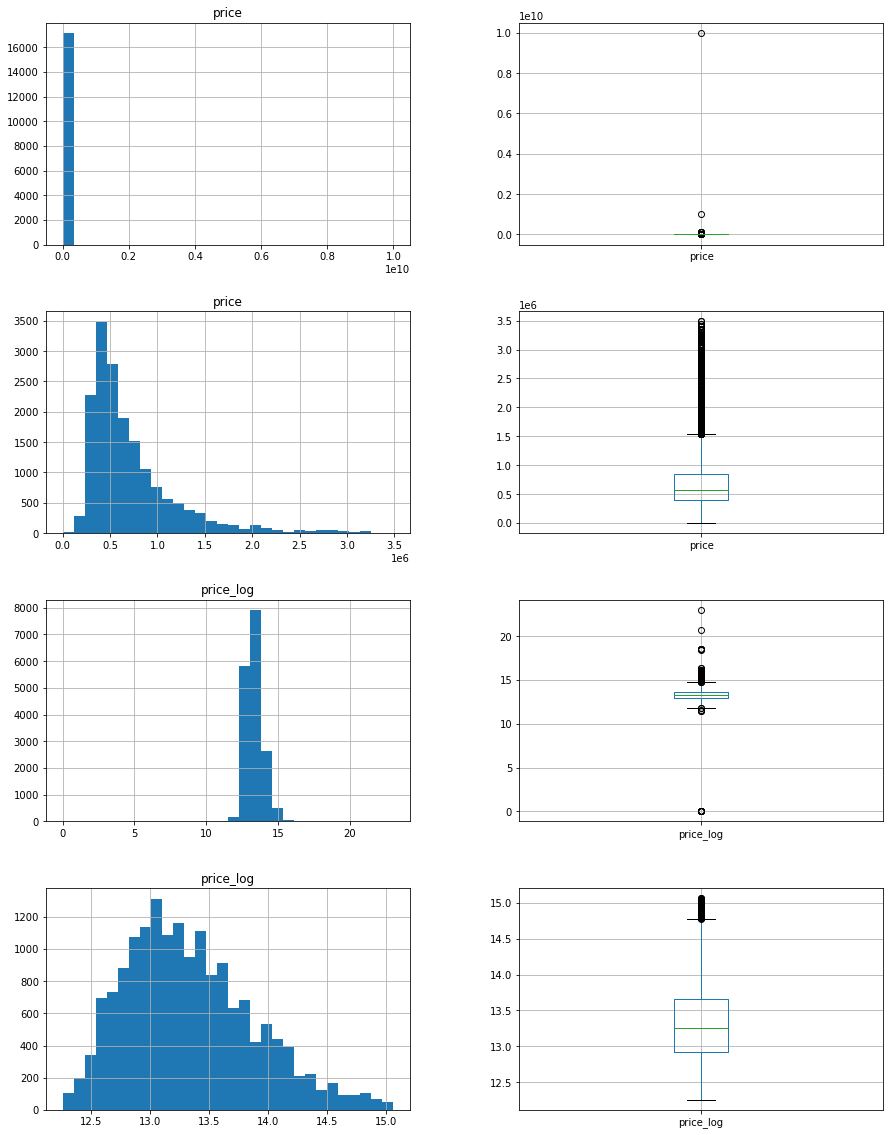

In [29]:
train['price_log'] = np.log( train['price'] )

plt.figure(figsize=(500,20))
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4,2, figsize=(15, 20))
fig.subplots_adjust(hspace=.8)

def sub_plot(data, column, ax1, ax2):
    data.hist(column, bins=30, ax=ax1)
    data.boxplot(column, ax=ax2)

sub_plot(train, 'price', ax1, ax2)
sub_plot(train[ train.price < np.percentile( train.price, 99 ) ], 'price', ax3, ax4)
sub_plot(train, 'price_log', ax5, ax6)
sub_plot(train[ (train.price_log > np.percentile( train.price_log, 1 )) & (train.price_log < np.percentile( train.price_log, 99 )) ], 'price_log', ax7, ax8)

In [30]:
def get_feats(df):
    feats = df.select_dtypes(include=[int, float]).columns 
    return feats[ (feats != 'price') & (feats != 'price_log') ].values

def get_X(df):
    feats = get_feats(df)
    return df[ get_feats(df) ].values

def get_y(df, target_var='price'):
    return df[target_var].values

def get_y_log(df, target_var='price_log'):
    return df[target_var].values


def get_models():
    return [
        ('dummy_mean', DummyRegressor(strategy='mean')),
        ('dummy_median', DummyRegressor(strategy='median'))
    ]

def run_cv(model, X, y, folds=4, target_log=False, cv_type=KFold, success_metric=rmsle):
    cv = cv_type(n_splits=folds)
    
    scores = []
    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        if target_log:
            y_train = np.log(y_train)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        if target_log:
            y_pred = np.exp(y_pred)
        
        y_pred[y_pred < 0] = 0 #иногда может быть отрицательное значение

        score = success_metric(y_test, y_pred)
        scores.append( score )
        
    return np.mean(scores), np.std(scores)


def plot_learning_curve(model, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), target_log=False):
    
    plt.figure(figsize=(12,8))
    plt.title(title)
    if ylim is not None:plt.ylim(*ylim)

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    if target_log:
        y = np.log(y)
    
    def my_scorer(model, X, y):
        y_pred = model.predict(X)
        
        if target_log:
            y = np.exp(y)
            y_pred = np.exp(y_pred)
            y_pred[ y_pred<0 ] = 0
        
        return rmsle(y, y_pred)

        
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=my_scorer)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


def run(train, plot_lc=False, folds=3, ylim=(0, 2), target_log=False):
    X, y  = get_X(train), get_y(train)

    for model_name, model in get_models():
        score_mean, score_std = run_cv(model, X, y, folds=folds, target_log=target_log)
        print("[{0}]: {1} +/-{2}".format(model_name, score_mean, score_std))
        sys.stdout.flush() #выводим результат сразу, без кэширования

        if False == plot_lc: continue
        plt = plot_learning_curve(model, model_name, X, y, ylim=ylim, cv=folds, target_log=target_log)
        plt.show()

In [31]:
X,y = get_X(train), get_y(train)


[dummy_mean]: 1.0691539140857458 +/-0.2799221428810655


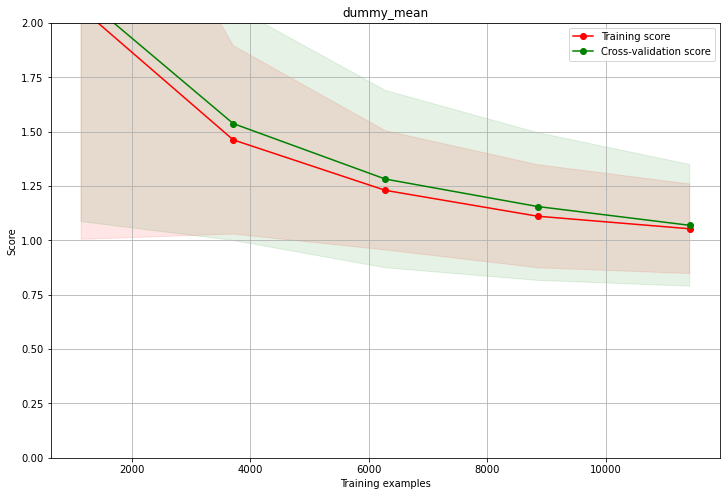

[dummy_median]: 0.6678517039942227 +/-0.06464186349579217


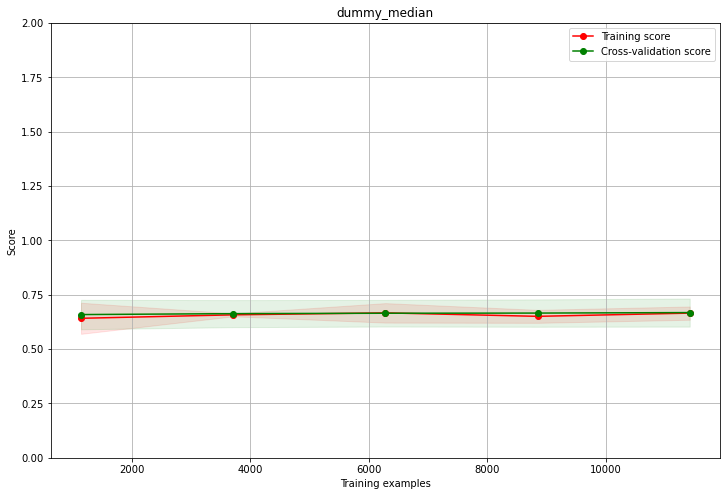

[dt-5md]: 0.5374152243787873 +/-0.09608831014028307


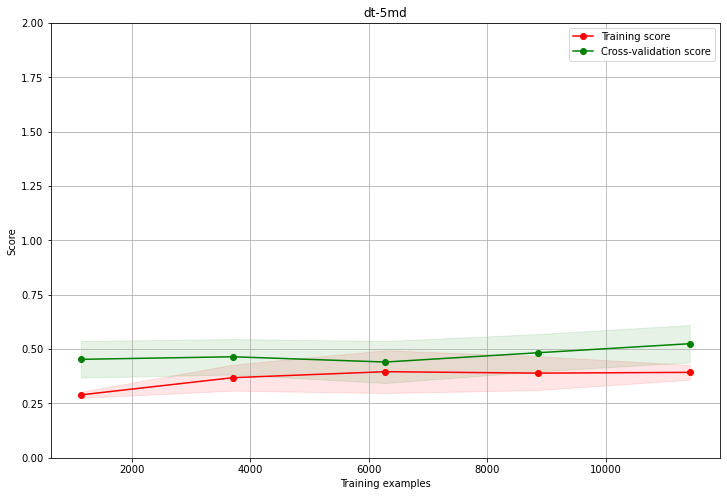

In [32]:
def get_models():
    return [
        ('dummy_mean', DummyRegressor(strategy='mean')),
        ('dummy_median', DummyRegressor(strategy='median')),
        ('dt-5md', DecisionTreeRegressor(max_depth=5)),
    ]

run(train, plot_lc=True)

[RF-20-5]: 0.462639721540347 +/-0.0855215020810472


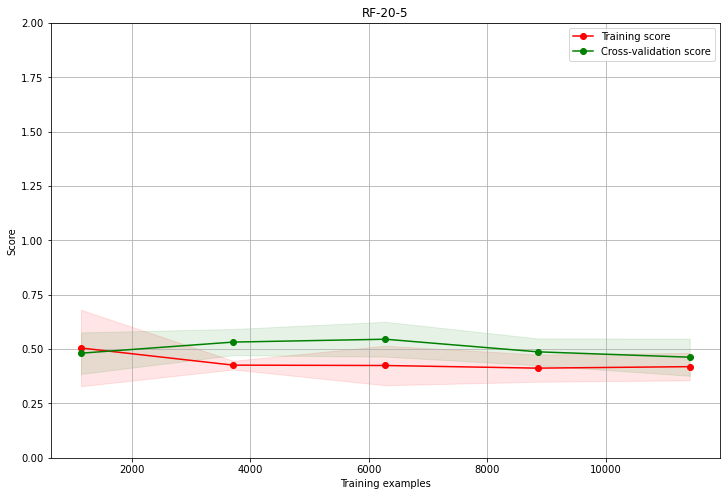

[RF-50-8]: 0.4809593077892454 +/-0.06032590818841083


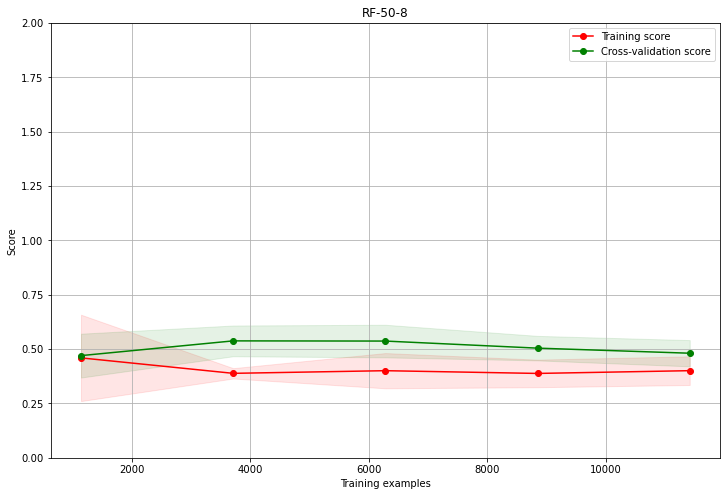

[ER-20-5]: 0.8955602475898896 +/-0.23006975728556556


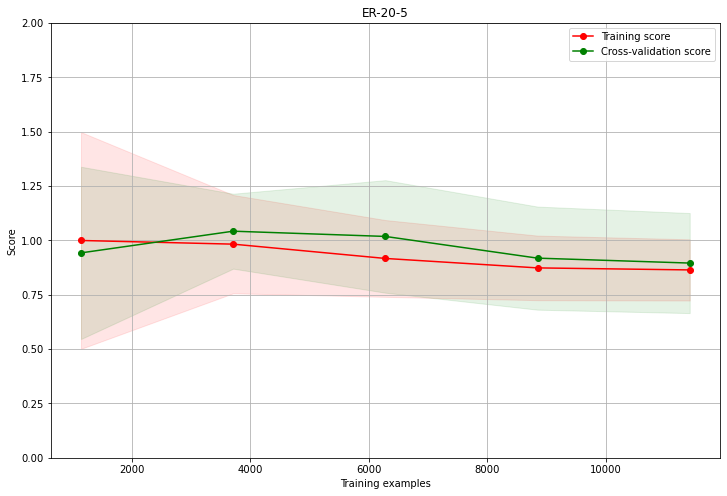

[ER-50-8]: 0.7104883072224664 +/-0.16259741849571113


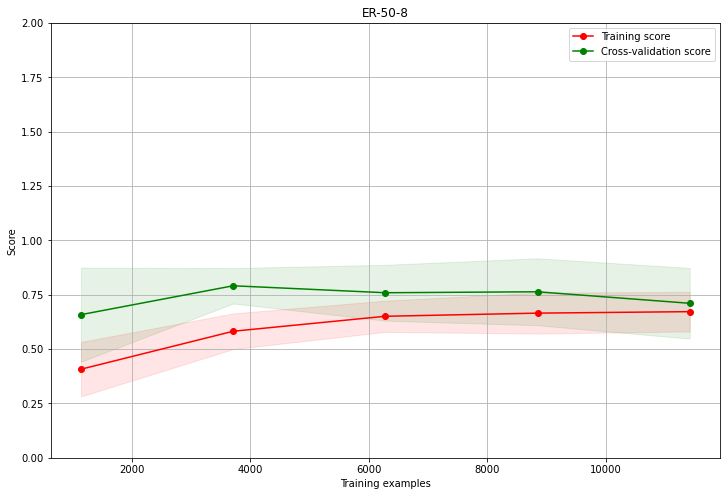

In [33]:
def get_models():
    return [
        ('RF-20-5', RandomForestRegressor(n_estimators=20,max_depth=5, random_state=0)),
         ('RF-50-8', RandomForestRegressor(n_estimators=50,max_depth=8, random_state=0)),
        ('ER-20-5', ExtraTreesRegressor(n_estimators=20,max_depth=5, random_state=0)),
        ('ER-50-8', ExtraTreesRegressor(n_estimators=50,max_depth=8, random_state=0)),
    ]

run(train, plot_lc=True)

# Feature engineering


In [34]:
def summary(values, percentiles=[1, 5, 95, 99, 100]):
    for percentile in percentiles:
        print('{0}th -> {1}'.format(percentile, np.percentile(values, percentile) ))

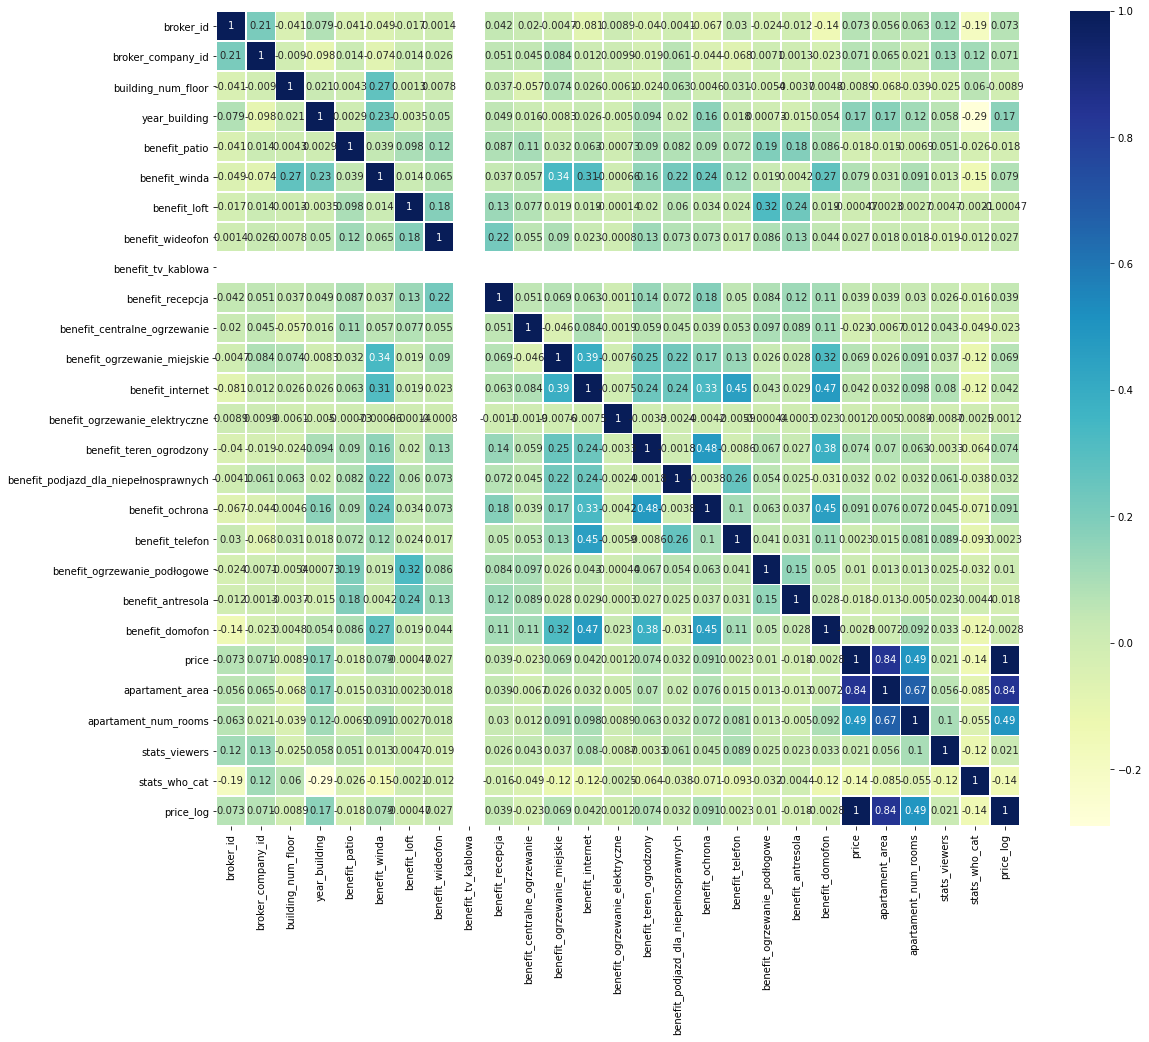

In [35]:
plt.rcParams['figure.figsize']=(18,15)
sns.heatmap(train.corr(method='spearman'), annot=True, linewidths=.8, cmap="YlGnBu");

## Площадь

Одним из признаков, который, безусловно, важен, является площадь собственности. Давай рассмотрим это более подробно.

1th -> 28.0
5th -> 36.0
95th -> 149.0
99th -> 215.83799999999974
100th -> 1140000.0


<AxesSubplot:>

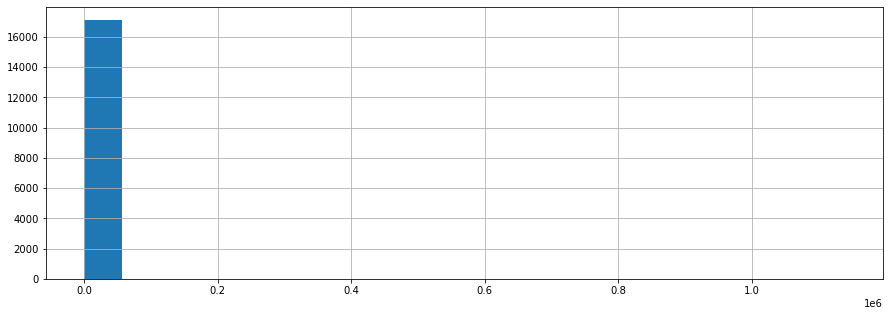

In [36]:
plt.rcParams['figure.figsize']=(15,5)

summary(train.apartament_area)
train.apartament_area.hist(bins=20)

Как можно увидеть, есть некоторые чрезвычайно большие площади. Самая большая **1 140 000** - это слишком много.

Можно увидеть, что **99. процентиль** составляет **~215.8m2**, и это нормально ... Давай посмотрим, сколько недвижимости с площадью больше, чем **400m2**.

In [37]:
train[ train.apartament_area > 400 ].apartament_area

0    1140000.00
0        425.00
0        407.90
0        417.11
0        600.00
0        476.00
0        424.00
0        483.37
0     515000.00
Name: apartament_area, dtype: float64

у нас есть два крайних случая: **1 140 000** и **515 000**. 

Выбросим все, что больше 500м2 (ровно 3 объекта).

Также сделаем гистограмму.

1th -> 28.0
5th -> 36.0
95th -> 149.0
99th -> 215.34
100th -> 483.37


<AxesSubplot:>

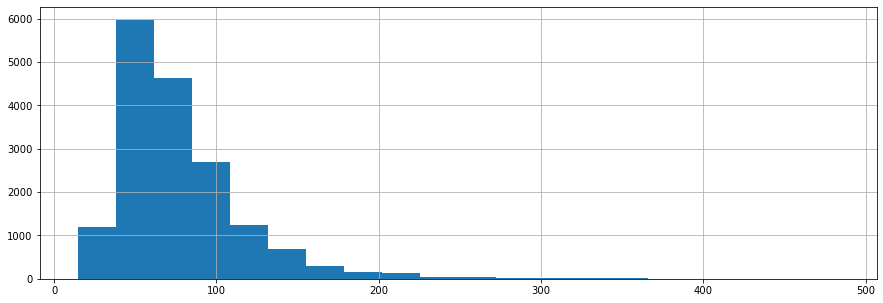

In [38]:
train = train[ train.apartament_area < 500 ]
summary(train.apartament_area)
train.apartament_area.hist(bins=20)

Теперь распределение видно лучше. 

<AxesSubplot:>

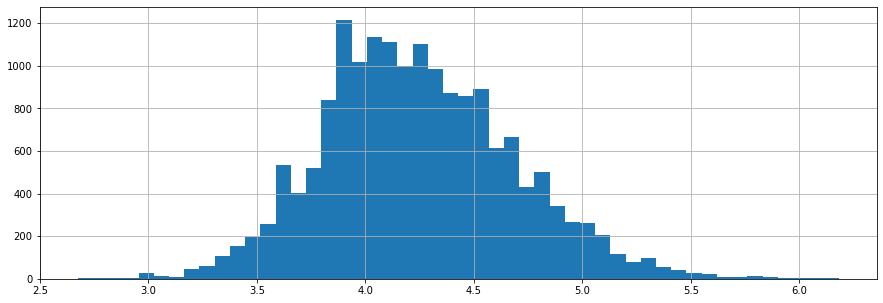

In [39]:
train['apartament_area_log'] = np.log( train.apartament_area )
train['apartament_area_log'].hist(bins=50)

Очень хорошо! Можно увидеть, что распределение симметрично, но давай посмотрим, дает ли это лучший результат. Кстати, давай сначала проверим, «поймала» ли функция `get_feats ()` новую переменную.

In [40]:
get_feats(train)

array(['building_num_floor', 'year_building', 'benefit_patio',
       'benefit_winda', 'benefit_loft', 'benefit_wideofon',
       'benefit_tv_kablowa', 'benefit_recepcja',
       'benefit_centralne_ogrzewanie', 'benefit_ogrzewanie_miejskie',
       'benefit_internet', 'benefit_ogrzewanie_elektryczne',
       'benefit_teren_ogrodzony', 'benefit_podjazd_dla_niepełnosprawnych',
       'benefit_ochrona', 'benefit_telefon',
       'benefit_ogrzewanie_podłogowe', 'benefit_antresola',
       'benefit_domofon', 'apartament_area', 'apartament_num_rooms',
       'stats_viewers', 'stats_who_cat', 'apartament_area_log'],
      dtype=object)

[RF-20-5]: 0.497649360587745 +/-0.05599796791289549


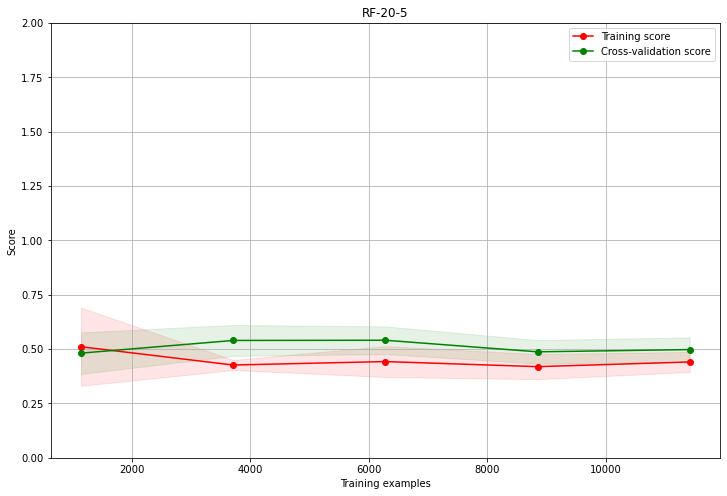

[RF-50-8]: 0.48189182908543526 +/-0.05527981078092037


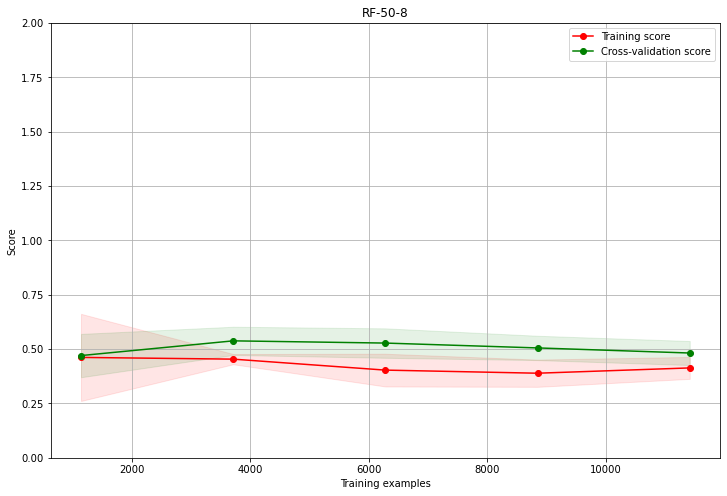

[ER-20-5]: 0.6713842624257861 +/-0.06640049406500868


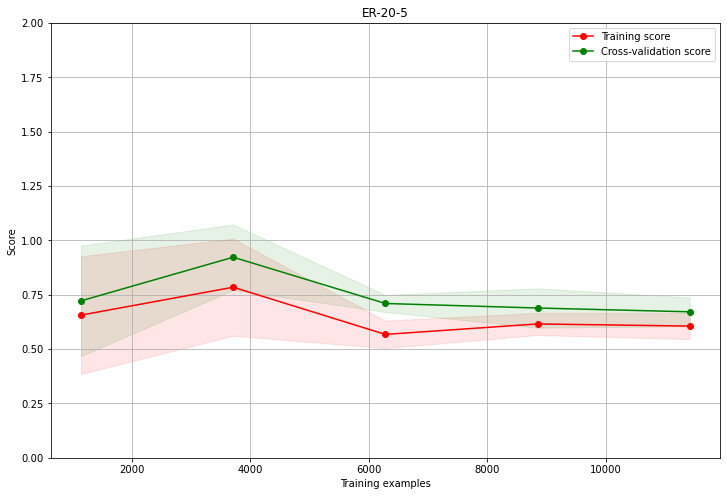

[ER-50-8]: 0.5421702804366361 +/-0.051246917494379665


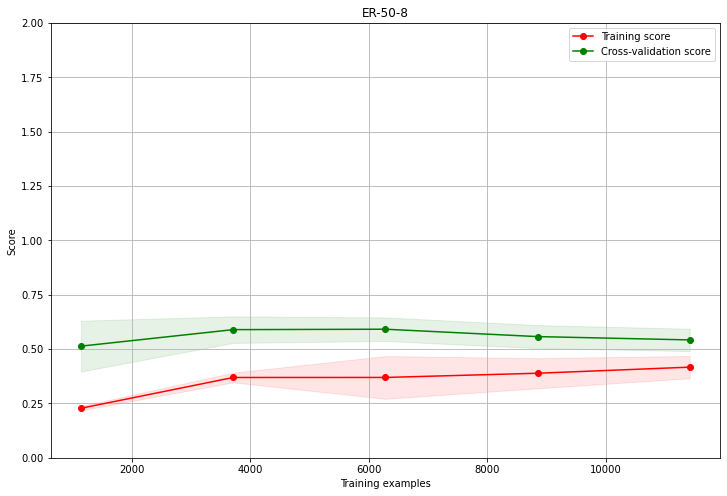

In [41]:
def get_models():
    return [
        ('RF-20-5', RandomForestRegressor(n_estimators=20,max_depth=5, random_state=0)),
        ('RF-50-8', RandomForestRegressor(n_estimators=50,max_depth=8, random_state=0)),
        ('ER-20-5', ExtraTreesRegressor(n_estimators=20,max_depth=5, random_state=0)),
        ('ER-50-8', ExtraTreesRegressor(n_estimators=50,max_depth=8, random_state=0)),
    ]

run(train, plot_lc=True)

## Кол-во этажей в здании

 4     3797
 3     3034
 5     1646
 6     1413
 10    1299
 2     1218
 7     1010
 8      900
-1      597
 12     460
 9      352
 11     320
 15     246
 1      198
 13     149
 16     113
 17     107
 14     100
 30      67
 22      27
 20      21
 18      13
 25       9
 19       9
 21       7
 23       6
 28       4
 24       3
Name: building_num_floor, dtype: int64


<AxesSubplot:>

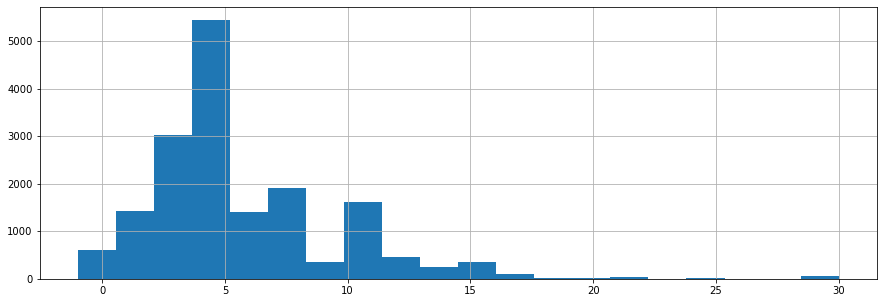

In [42]:
print( train.building_num_floor.value_counts() )
train['building_num_floor'].hist(bins=20)

<AxesSubplot:>

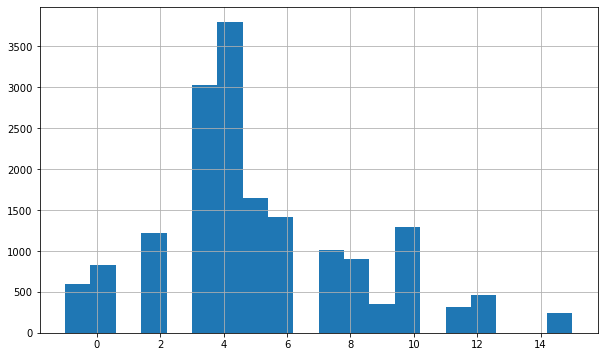

In [43]:
cnt_values = train.building_num_floor.value_counts().reset_index()
other_floor = set(cnt_values[ cnt_values.building_num_floor < 200 ]['index'].values)

train['building_num_floor_other'] = train.building_num_floor.map(lambda x: 0 if x in other_floor else x)
train['building_num_floor_other'].hist(bins=20, figsize=(10, 6))

In [45]:
df_ohe = pd.get_dummies(train['building_num_floor_other'], prefix='building_num_floor')
df_ohe.head()

,building_num_floor_-1,building_num_floor_0,building_num_floor_2,building_num_floor_3,building_num_floor_4,building_num_floor_5,building_num_floor_6,building_num_floor_7,building_num_floor_8,building_num_floor_9,building_num_floor_10,building_num_floor_11,building_num_floor_12,building_num_floor_15
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [46]:
#размеры после склейки
train = pd.concat([train, df_ohe], axis=1)
train.shape

(17125, 68)

## На каком этаже находится недвижимость?
На этот раз нас интересует, на каком этаже находится квартира. Я думаю, что стоит сделать две отдельные переменные - находится ли недвижимость на первом или верхнем этаже. Предполагая, что это должно повлиять на модель.

In [47]:
train['apartament_floor'].value_counts()

1             3254
3             3090
2             3021
parter        2101
4             1801
5             1148
6              631
7              490
8              367
9              294
10             263
-1             231
11             148
12              70
14              59
13              42
15              38
powyżej 30      21
poddasze        20
16              14
17              12
19               4
20               2
26               1
18               1
21               1
25               1
Name: apartament_floor, dtype: int64

Работать со «string» довольно сложно, поэтому давай сопоставим все с «int», например, цокольный этаж (parter), естественно, будет 0. Выше (powyżej) 30 будет просто 30, потому что, как видишь, есть свободное место, на чердаке(poddasze) можно дать большее число, например 50.

<AxesSubplot:>

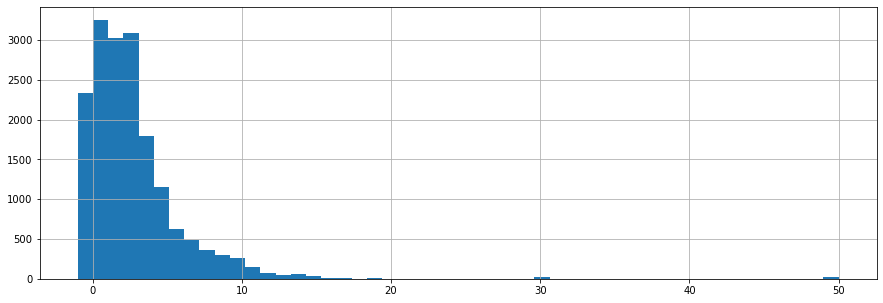

In [48]:
map_floor = {
    'parter': 0,
    'poddasze': 50,
    'powyżej 30': 30
}

train['apartament_floor'] = train.apartament_floor.map(lambda x: map_floor[x] if x in map_floor else int(x)).astype('int8')
train['apartament_floor'].hist(bins=50)

In [53]:
train['apartament_last_floor'] = train.building_num_floor == train.apartament_floor
train['apartament_last_floor']=train['apartament_last_floor'].factorize()[0]
train['apartament_one_before_last_floor'] = train.building_num_floor == (train.apartament_floor - 1)
train['apartament_one_before_last_floor']=train['apartament_one_before_last_floor'].factorize()[0]
train['apartament_parter'] = train.apartament_floor == 0
train['apartament_parter']=train['apartament_parter'].factorize()[0]

train['apartament_floor_winda']=train.apply(lambda x: "{}-{}".format(x['apartament_floor'], x['benefit_winda']), axis=1)
train['apartament_floor_winda'] =train['apartament_floor_winda'].factorize()[0]
train['parking'] =train['parking'].factorize()[0]
train['benefit_investment']= train['benefit_investment'].factorize()[0]
train['type_building']= train['type_building'].factorize()[0]

In [55]:
train.head()

,parking,apartament,surroundings,extra_description,benefit_investment,broker_license,broker_id,broker_company_id,building_num_floor,type_building,...,building_num_floor_8,building_num_floor_9,building_num_floor_10,building_num_floor_11,building_num_floor_12,building_num_floor_15,apartament_last_floor,apartament_one_before_last_floor,apartament_parter,apartament_floor_winda
0,0,"{'Łazienka': 'w aneksie', 'Liczba pokoi': 'par...",{'Zdrowie': [' ...,[OSTATNIE WOLNE LOKALE !!!!!!!!!! OSIED...,0,,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0
0,1,"{'Liczba pokoi': '8', 'Kuchnia': 'bardzo dobry...",{'Zdrowie': [' ...,[Mieszkanie typu studio na warszawskiej Ochoci...,0,,1,1,8,0,...,1,0,0,0,0,0,1,0,1,1
0,1,"{'Łazienka': 'z oknem, oddzielna', 'Liczba pok...",{'Zdrowie': [' ...,"[Oferujemy mieszkanie na 3 piętrze, dwustronne...",0,,2,0,4,1,...,0,0,0,0,0,0,0,0,1,2
0,1,"{'Liczba pokoi': 'parter', 'Kuchnia': 'do remo...",{},"[Witam, oferuję Państwu mieszkanie na spokojny...",0,Nr licencji pośrednika: 11710,3,2,4,1,...,0,0,0,0,0,0,0,0,0,0
0,1,"{'Liczba pokoi': '3', 'Kuchnia': '3', 'Forma w...",{'Zdrowie': [' ...,[Jeśli chcesz mieszkać w doskonale skomunikowa...,0,,4,3,3,1,...,0,0,0,0,0,0,1,0,1,2


In [56]:
get_feats(train)

array(['parking', 'benefit_investment', 'building_num_floor',
       'type_building', 'year_building', 'benefit_patio', 'benefit_winda',
       'benefit_loft', 'benefit_wideofon', 'benefit_tv_kablowa',
       'benefit_recepcja', 'benefit_centralne_ogrzewanie',
       'benefit_ogrzewanie_miejskie', 'benefit_internet',
       'benefit_ogrzewanie_elektryczne', 'benefit_teren_ogrodzony',
       'benefit_podjazd_dla_niepełnosprawnych', 'benefit_ochrona',
       'benefit_telefon', 'benefit_ogrzewanie_podłogowe',
       'benefit_antresola', 'benefit_domofon', 'apartament_area',
       'apartament_num_rooms', 'stats_viewers', 'stats_who_cat',
       'apartament_area_log', 'building_num_floor_other',
       'apartament_last_floor', 'apartament_one_before_last_floor',
       'apartament_parter', 'apartament_floor_winda'], dtype=object)

[XGBoost]: 0.41489662848437 +/-0.10557583835077448


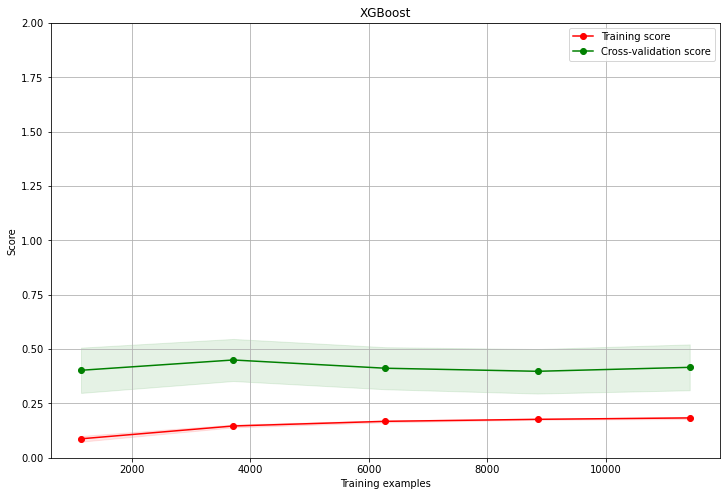

[CatBoost]: 0.42128267189018564 +/-0.11088156472001194


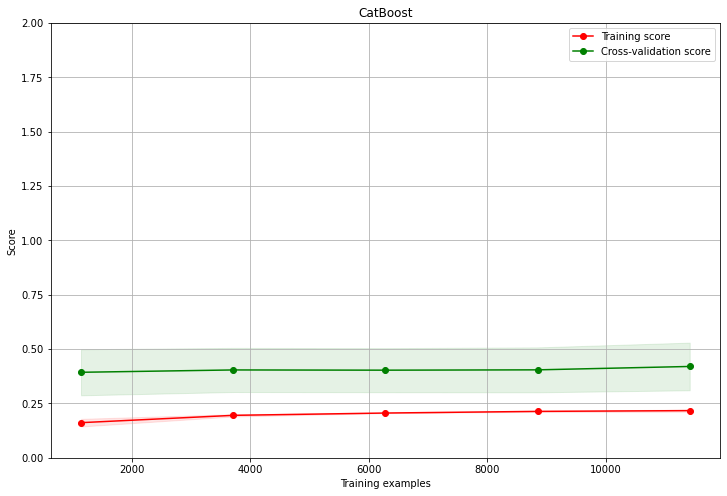

In [76]:

def get_models():
    return [
        
        ('XGBoost', xgb.XGBRegressor(max_depth=5, n_estimators=300, random_state=0, learning_rate =0.1)),
        ('CatBoost',ctb.CatBoostRegressor(n_estimators=300, depth=5, random_state=0, verbose=False)),
    ]

run(train, plot_lc=True, target_log=True)